# **Delta Hedging with SPX Options**

This simulation models the pricing and delta sensitivity of an at-the-money (ATM) SPX call option over time and demonstrates the effectiveness of delta hedging in managing option risk. In this approach, we will long an SPX option at a delta of 0.5 (At-The-Money) and a one-month maturity. Implied volatility will be used to perform dynamic delta hedging throughout the option's life, with adjustments made continuously until the option expires.

*We will use the VIX to represent implied volatility and constant annualized risk-free rate.

In [91]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis

# Download VIX data
vix_data = yf.download('^VIX', start="2006-03-01", end="2024-12-20")
print(vix_data.head())

# Download SPX data
spx_ticker = "^GSPC"
spx_data = yf.download(spx_ticker, start="2006-03-01", end="2024-12-20", interval="1d")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price                     Adj Close  Close   High    Low   Open Volume
Ticker                         ^VIX   ^VIX   ^VIX   ^VIX   ^VIX   ^VIX
Date                                                                  
2006-03-01 00:00:00+00:00     11.54  11.54  12.07  11.52  12.05      0
2006-03-02 00:00:00+00:00     11.72  11.72  11.95  11.56  11.79      0
2006-03-03 00:00:00+00:00     11.96  11.96  12.10  11.36  12.03      0
2006-03-06 00:00:00+00:00     12.74  12.74  12.91  12.22  12.22      0
2006-03-07 00:00:00+00:00     12.66  12.66  13.34  12.64  12.92      0


In [5]:
from google.colab import files
uploaded = files.upload()

file_names = list(uploaded.keys())

expiration_data = pd.read_csv(file_names[0])
expiration_data['Expiration'] = pd.to_datetime(expiration_data['Expiration'], format='%m/%d/%y')

Saving expiration.csv to expiration.csv


Now that we have our data, we need to reformat it so that we can use it efficiently. vix_data and spx_data have multilevel indexes. By taking the second level values and retaining only the "Close" column, we create new dataframes that only include the date and closing price of VIX and SPX. We  reset the index to make 'Date' a regular column and then merge the datasets by date.

In [92]:
# For VIX data
vix_data.columns = vix_data.columns.get_level_values(1)  # Flatten the multi-level columns
vix_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
vix_vol = vix_data[['Close']].copy()  # Extract Close column
vix_vol.index = pd.to_datetime(vix_vol.index).normalize().tz_localize(None)  # Normalize and remove timezone
vix_vol.reset_index(inplace=True)  # Reset the index and add it as a column
vix_vol.rename(columns={'index': 'Date'}, inplace=True)  # Rename 'index' column to 'Date'

# For SPX data
spx_data.columns = spx_data.columns.get_level_values(1)
spx_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
spx_data = spx_data[['Close']].copy()  # Extract Close column
spx_data.index = pd.to_datetime(spx_data.index).normalize().tz_localize(None)
spx_data.reset_index(inplace=True)
spx_data.rename(columns={'index': 'Date'}, inplace=True)

backtest_data = pd.merge(spx_data[['Date', 'Close']], vix_vol[['Date', 'Close']], on='Date', suffixes=('_spx', '_vix'))

Then merging our vix and spx data with contract expiration dates.

In [93]:
merged_data = pd.merge_asof(
    backtest_data,
    expiration_data,
    left_on='Date',
    right_on='Expiration',
    direction='forward'
)

In [106]:
print(merged_data.head())

        Date    Close_spx  Close_vix Expiration
0 2006-03-01  1280.660034      11.52 2006-03-24
1 2006-03-02  1283.209961      11.56 2006-03-24
2 2006-03-03  1284.199951      11.36 2006-03-24
3 2006-03-06  1275.670044      12.22 2006-03-24
4 2006-03-07  1271.109985      12.64 2006-03-24


Using the Black-Scholes model, we calculate the theoretical price and delta of a one-month ATM SPX call option. We define the Black-Scholes formula function:

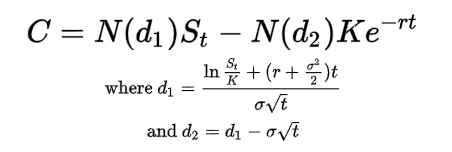

In [94]:
# Assume a fixed annualized risk-free rate of 4%
risk_free_rate = 0.04
spx_complete = merged_data

# Calculate Days to Maturity and T
spx_complete['Days_to_Maturity'] = (spx_complete['Expiration'] - spx_complete['Date']).dt.days
spx_complete['T'] = spx_complete['Days_to_Maturity'] / 365

def black_scholes(S, K, T, r, sigma):
    sigma = max(sigma, 1e-6)  # Avoid zero or near-zero volatility
    T = max(T, 1e-6)  # Avoid zero or near-zero time to maturity
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Calculate call option price and delta
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta

# Apply Black-Scholes to calculate option prices and deltas
spx_complete[['Option_Price', 'Delta']] = spx_complete.apply(
    lambda row: black_scholes(
        row['Close_spx'],  # S = SPX Close Price
        row['Close_spx'],  # K = ATM Strike Price
        row['T'],  # T = Time to Maturity in years
        risk_free_rate,  # r = Fixed Annualized Risk-Free Rate (4%)
        row['Close_vix'] / 100  # Convert VIX to decimal form
    ),
    axis=1,
    result_type="expand"
)

In [53]:
print(spx_complete.head())

        Date    Close_spx  Close_vix Expiration  Days_to_Maturity         T  \
0 2006-03-01  1280.660034      11.52 2006-03-24                23  0.063014   
1 2006-03-02  1283.209961      11.56 2006-03-24                22  0.060274   
2 2006-03-03  1284.199951      11.36 2006-03-24                21  0.057534   
3 2006-03-06  1275.670044      12.22 2006-03-24                18  0.049315   
4 2006-03-07  1271.109985      12.64 2006-03-24                17  0.046575   

   Option_Price     Delta  
0     16.423387  0.540471  
1     16.108191  0.539487  
2     15.469195  0.539067  
3     15.089857  0.534370  
4     15.034920  0.532651  


To maintain a delta-neutral portfolio, SPX stock is shorted in proportion to the option's delta. At the beginning of each month, the strike price is reset to the current SPX level, reflecting a strategy of initiating a new ATM option monthly. The simulation evaluates the effectiveness of delta hedging under two scenarios: daily rebalancing, where the hedge is dynamically adjusted daily to maintain delta neutrality, and monthly rebalancing, where adjustments are made only at the start of each month. By comparing these approaches, the simulation highlights the trade-offs between hedging accuracy, transaction costs, and portfolio performance, demonstrating how delta hedging can mitigate risk effectively under different rebalancing frequencies.

In [95]:
Q = 100  # Quantity of options
transaction_cost_rate = 0.0005  # Transaction cost (0.05% per transaction)
risk_free_rate = 0.04  # Annualized risk-free rate (4%)

# Initial values
spx_complete.at[0, 'Hedging_Position'] = -spx_complete.at[0, 'Delta'] * Q
spx_complete.at[0, 'Transaction_Cost'] = abs(spx_complete.at[0, 'Hedging_Position']) * spx_complete.at[0, 'Close_spx'] * transaction_cost_rate
spx_complete.at[0, 'Cash_Position'] = -spx_complete.at[0, 'Hedging_Position'] * spx_complete.at[0, 'Close_spx'] - spx_complete.at[0, 'Transaction_Cost']
spx_complete.at[0, 'Interest_Accrued'] = 0.0  # No interest accrued on Day 0
spx_complete.at[0, 'Portfolio_Value'] = spx_complete.at[0, 'Cash_Position']

# Accrue interest from Day 1 onward
for i in range(1, len(spx_complete)):
    spx_complete.at[i, 'Interest_Accrued'] = spx_complete.at[i-1, 'Cash_Position'] * (risk_free_rate / 365)
    spx_complete.at[i, 'Portfolio_Value'] = spx_complete.at[i, 'Cash_Position'] + spx_complete.at[i, 'Interest_Accrued']
    current_row = spx_complete.iloc[i]
    previous_row = spx_complete.iloc[i - 1]

    # Recalculate option price and delta
    option_price, delta = black_scholes(
        current_row['Close_spx'],
        current_row['Close_spx'],  # ATM strike price
        current_row['T'],  # Time to maturity in years
        risk_free_rate,  # Risk-free rate
        current_row['Close_vix'] / 100  # Implied volatility in decimal
    )

    spx_complete.at[i, 'Option_Price'] = option_price
    spx_complete.at[i, 'Delta'] = delta

    # Adjust hedging position
    new_hedging_position = -delta * Q
    position_change = new_hedging_position - previous_row['Hedging_Position']
    transaction_cost = transaction_cost_rate * abs(position_change) * current_row['Close_spx']

    spx_complete.at[i, 'Hedging_Position'] = new_hedging_position
    spx_complete.at[i, 'Transaction_Cost'] = transaction_cost

    # Update cash position
    cash_change = -position_change * current_row['Close_spx'] - transaction_cost
    new_cash_position = previous_row['Cash_Position'] + cash_change
    spx_complete.at[i, 'Cash_Position'] = new_cash_position

    # Accrue interest on cash
    interest_accrued = new_cash_position * (risk_free_rate / 365)
    spx_complete.at[i, 'Interest_Accrued'] = interest_accrued
    portfolio_value = option_price * Q + new_cash_position + interest_accrued
    spx_complete.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate daily PnL
spx_complete['Daily_PnL'] = spx_complete['Portfolio_Value'].diff()

Then we rebalance monthly:

In [96]:
# Define function to check if the current row is the start of a new month
def is_month_start(current_date, previous_date):
    return current_date.month != previous_date.month

# Create a copy of the dataframe
spx_copy = spx_complete.copy()

# Initialize constants and variables
Q = 100
transaction_cost_rate = 0.0005
risk_free_rate = 0.04

# Add new columns in the copied dataframe
spx_copy['Hedging_Position'] = 0.0
spx_copy['Transaction_Cost'] = 0.0
spx_copy['Cash_Position'] = 0.0
spx_copy['Portfolio_Value'] = 0.0
spx_copy['Interest_Accrued'] = 0.0

# Initial values (Day 0)
spx_copy.at[0, 'Hedging_Position'] = -spx_copy.at[0, 'Delta'] * Q
spx_copy.at[0, 'Transaction_Cost'] = abs(spx_copy.at[0, 'Hedging_Position']) * spx_copy.at[0, 'Close_spx'] * transaction_cost_rate
spx_copy.at[0, 'Cash_Position'] = -spx_copy.at[0, 'Hedging_Position'] * spx_copy.at[0, 'Close_spx'] - spx_copy.at[0, 'Transaction_Cost']
spx_copy.at[0, 'Portfolio_Value'] = spx_copy.at[0, 'Option_Price'] * Q + spx_copy.at[0, 'Cash_Position']

# Loop through each day to compute daily values
for i in range(1, len(spx_copy)):
    # Current and previous rows
    current_row = spx_copy.iloc[i]
    previous_row = spx_copy.iloc[i - 1]

    # Accrue daily interest on the cash position
    interest_accrued = previous_row['Cash_Position'] * (risk_free_rate / 365)
    spx_copy.at[i, 'Interest_Accrued'] = interest_accrued

    # Check if it's the start of a new month
    if is_month_start(current_row['Date'], previous_row['Date']):
        # Rebalance hedging position
        new_hedging_position = -current_row['Delta'] * Q
        position_change = new_hedging_position - previous_row['Hedging_Position']
        transaction_cost = transaction_cost_rate * abs(position_change) * current_row['Close_spx']

        spx_copy.at[i, 'Hedging_Position'] = new_hedging_position
        spx_copy.at[i, 'Transaction_Cost'] = transaction_cost

        # Update cash position due to rebalancing
        cash_change = -position_change * current_row['Close_spx'] - transaction_cost
        new_cash_position = previous_row['Cash_Position'] + cash_change
    else:
        # No rebalancing; carry forward hedging position and cash position
        spx_copy.at[i, 'Hedging_Position'] = previous_row['Hedging_Position']
        spx_copy.at[i, 'Transaction_Cost'] = 0.0
        new_cash_position = previous_row['Cash_Position']

    # Update cash position with interest accrued
    new_cash_position += interest_accrued
    spx_copy.at[i, 'Cash_Position'] = new_cash_position

    # Calculate portfolio value
    portfolio_value = current_row['Option_Price'] * Q + new_cash_position
    spx_copy.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate daily PnL
spx_copy['Daily_PnL'] = spx_copy['Portfolio_Value'].diff()

We now plot our cumulative and monthly PnL to visualize our delta hedging strategy as well as the impact of rebalancing frequency.

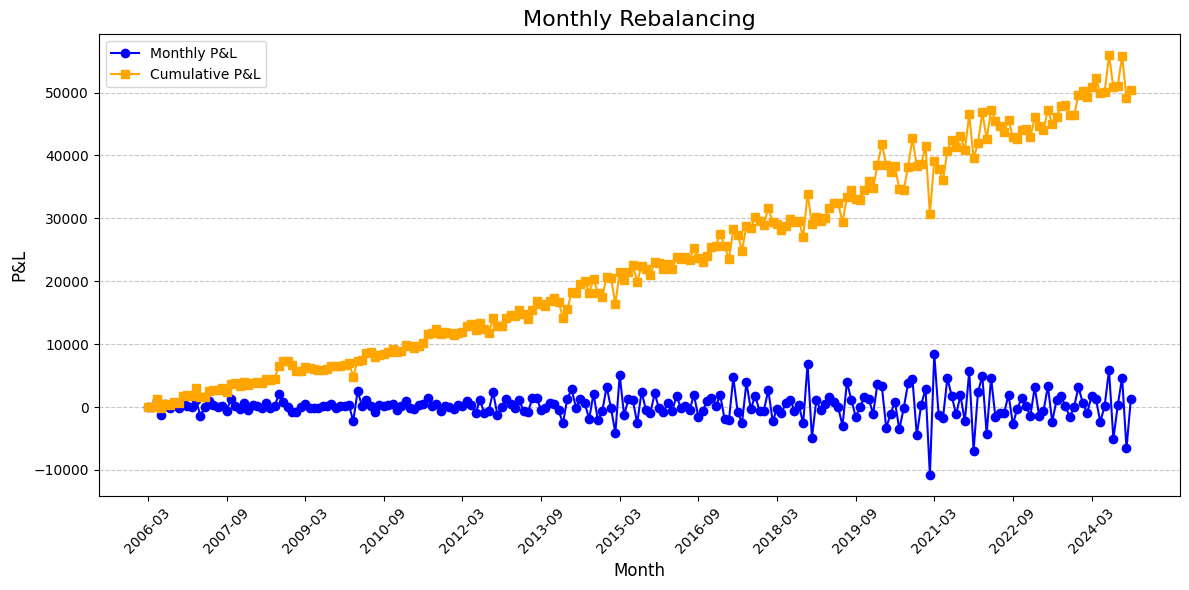

In [107]:
spx_copy['Month'] = spx_copy['Date'].dt.to_period('M')
monthly_pnl = spx_copy.groupby('Month')['Daily_PnL'].sum().reset_index()
monthly_pnl.rename(columns={'Daily_PnL': 'Monthly_PnL'}, inplace=True)
monthly_pnl['Cumulative_PnL'] = monthly_pnl['Monthly_PnL'].cumsum()

# Convert 'Month' to string for easier plotting
monthly_pnl['Month_Str'] = monthly_pnl['Month'].astype(str)

# Create the plot
plt.figure(figsize=(12, 6))

# Line plot for Monthly PnL
plt.plot(
    monthly_pnl['Month_Str'],
    monthly_pnl['Monthly_PnL'],
    marker='o',
    label='Monthly P&L',
    color='blue',
    linestyle='-'
)

# Line plot for Cumulative PnL
plt.plot(
    monthly_pnl['Month_Str'],
    monthly_pnl['Cumulative_PnL'],
    marker='s',
    label='Cumulative P&L',
    color='orange',
    linestyle='-'
)

# Add titles and labels
plt.title('Monthly Rebalancing', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('P&L', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

step = max(1, len(monthly_pnl['Month_Str']) // 12)
plt.xticks(ticks=range(0, len(monthly_pnl['Month_Str']), step), labels=monthly_pnl['Month_Str'][::step], rotation=45)

plt.tight_layout()
plt.show()

# Monthly Rebalancing

**Monthly P&L**:
The blue line shows the monthly profit and loss (P&L) for the portfolio.
It fluctuates over time, reflecting the realized gains or losses from the changes in the SPX call option value, adjusted for transaction costs incurred during monthly rebalancing.

**Cumulative P&L**:
The orange line represents the cumulative profit and loss over the time horizon.
This line steadily increases, suggesting that the strategy generates an overall profit over time, despite individual monthly fluctuations.

The cumulative P&L shows a generally upward trend, indicating the strategy's long-term profitability.
Monthly P&L oscillates around a relatively stable range, showing the variability inherent in short-term market movements and transaction cost impacts.

The strategy of longing the call option and rebalancing monthly appears to be profitable overall, with the cumulative P&L rising significantly over the observed period. Transaction costs (0.05% per rebalancing) and market volatility contribute to the short-term P&L fluctuations. The strategy's profitability suggests that the gains from holding the call option outweigh the rebalancing transaction costs and market-induced variability over the long term.

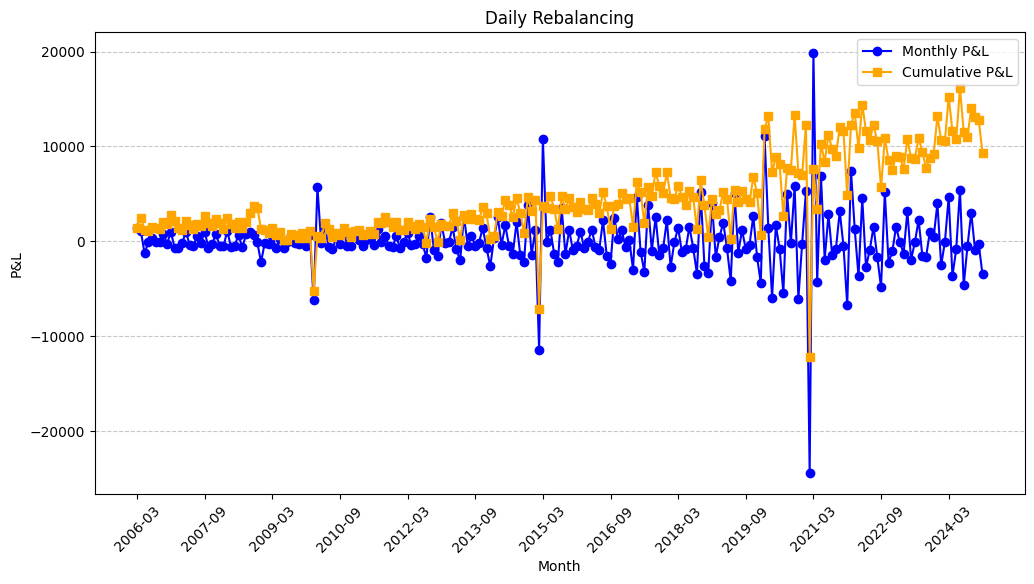

In [106]:
spx_complete['Month'] = spx_complete['Date'].dt.to_period('M')

# Calculate Monthly P&L
monthly_pnl = spx_complete.groupby('Month')['Daily_PnL'].sum().reset_index()
monthly_pnl.rename(columns={'Daily_PnL': 'Monthly_PnL'}, inplace=True)
spx_complete['Cumulative_PnL'] = spx_complete['Daily_PnL'].cumsum()
monthly_pnl['Cumulative_PnL'] = monthly_pnl['Monthly_PnL'].cumsum()

# Simplify x-axis
plt.figure(figsize=(12, 6))

# Convert 'Month' column to string
monthly_pnl['Month_Str'] = monthly_pnl['Month'].astype(str)

# Line plot for Monthly P&L
plt.plot(monthly_pnl['Month_Str'], monthly_pnl['Monthly_PnL'], marker='o', label='Monthly P&L', color='blue')

# Line plot for Cumulative P&L
plt.plot(monthly_pnl['Month_Str'], monthly_pnl['Cumulative_PnL'], marker='s', label='Cumulative P&L', color='orange')

# Formatting
plt.title('Daily Rebalancing')
plt.xlabel('Month')
plt.ylabel('P&L')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Simplify x-axis ticks
step = len(monthly_pnl['Month_Str']) // 12  # Show only 12 ticks
plt.xticks(ticks=monthly_pnl['Month_Str'][::step], rotation=45)

# Show plot
plt.show()

## Daily Rebalancing

**Monthly P&L**:

The blue line shows the portfolio's monthly profit and loss (P&L).
There is notable variability, with large spikes and dips indicating significant fluctuations in the portfolio's value over time.

**Cumulative P&L**:

The orange line tracks the cumulative profit and loss of the portfolio over time. Unlike the smoother upward trend in the monthly rebalancing strategy, this plot shows periods of stagnation and even sharp declines, reflecting the impact of frequent rebalancing and transaction costs.

The cumulative P&L grows modestly over time but exhibits more pronounced drawdowns compared to the monthly rebalancing strategy. Large negative P&L spikes in the monthly series suggest instances of heightened volatility or significant costs incurred from rebalancing in response to rapid market movements.

The frequent adjustments required to maintain a delta-neutral position increase transaction costs that reduce profitability during periods of high market volatility or frequent price changes. Compared to monthly rebalancing, daily rebalancing introduces higher P&L variability. While the strategy manages to achieve some cumulative profit, the magnitude and frequency of losses make daily rebalancing less appealing compared to monthly rebalancing.



# Takeaways:

Delta hedging effectively mitigates directional risk by adjusting the position in the underlying asset to offset changes in the option's delta. However, its performance depends heavily on the rebalancing frequency, transaction costs, and market conditions (e.g., volatility).

While daily rebalancing theoretically ensures a more accurate hedge, the associated costs and increased volatility make it impractical for many strategies. Monthly rebalancing offers a more balanced approach, reducing costs while still providing effective risk management.
